In [1]:
!pip install pingouin pycirclize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=3fc8e4ed0dc0e58d80a5a2eeb57c45c9e9f379df461d5ce0454c778b385c5d84
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstats
import pingouin

In [4]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
plt.rcParams['font.size'] = 7
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["svg.fonttype"] = "path"

In [ ]:
# this is for Zhen-Qi, change it when you run it
data_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [5]:
# this is for Haley
data_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [6]:
mend_pls_result = h5py.File(data_dir / "MEND_pls_result.hdf5")

In [7]:
mend_pls_all = pd.read_csv(data_dir / "MEND_PLS_all.csv")
post_hoc = mend_pls_all[["ID", "PatientType2", "AgeAtBaseline", "sex"]].rename({
    "AgeAtBaseline": "age"
})
with h5py.File(data_dir / "MEND_pls_result.hdf5") as f:
    post_hoc['LC1_brain'] = f["results"]["x_scores"][:, 0]
    post_hoc['LC1_behv'] = f["results"]["y_scores"][:, 0]

In [8]:
group_names = ["Schizophrenia", "Schizoaffective disorder", "Psychotic mood disorders"]
group_names_short = ["Schizophrenia", "Schizoaffective\ndisorder", "Psychotic mood\ndisorders"]

In [9]:
# Define a function to set the values of column "A" based on column "B"
def set_value(row):
    if row['PatientType2'] == 2:
        return group_names[0]
    elif row['PatientType2'] == 3:
        return group_names[1]
    elif row['PatientType2'] == 5:
        return group_names[2]

# Apply the function to create column "A"
post_hoc['group'] = post_hoc.apply(set_value, axis=1)

In [10]:
ENIGMA = pd.read_csv(data_dir / 'ENIGMA_DUP+MED.csv')
post_hoc = pd.merge(ENIGMA, post_hoc, on='ID', how='left')
post_hoc = post_hoc.dropna(subset=['LC1_brain'])
post_hoc = post_hoc.rename({
    'Duration of illness  at MR (months)': 'dup',
    'Non-Cumulative chlorpromazine equivalents ': 'med'
     })

In [11]:
post_hoc['group'] = pd.Categorical(post_hoc['group'], categories=group_names, ordered=True)
post_hoc['group_code'] = post_hoc['group'].cat.codes

In [12]:
x_scores_grouped = [post_hoc['LC1_brain'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]
y_scores_grouped = [post_hoc['LC1_behv'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]

In [13]:
from matplotlib.colors import ListedColormap, to_rgb, to_hex
pal_bgo_3 = ["#31A9E7", "#305861", "#F19100"]
cmap_bgo_3 = ListedColormap([to_rgb(_) for _ in pal_bgo_3])

In [14]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

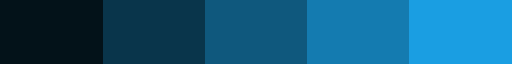

In [ ]:
ListedColormap([to_hex(scale_lightness(to_rgb(pal_bgo_3[0]), _)) for _ in [0.1, 0.3, 0.5, 0.7, 0.9]])

In [ ]:
score_corr_r, score_corr_p = sstats.pearsonr(mend_pls_result["results"]["x_scores"][:, 0], mend_pls_result["results"]["y_scores"][:, 0])

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(mend_pls_result["results"]["x_scores"][:, 0].reshape(-1, 1), mend_pls_result["results"]["y_scores"][:, 0].reshape(-1, 1))
b = reg.intercept_
m = reg.coef_[0]

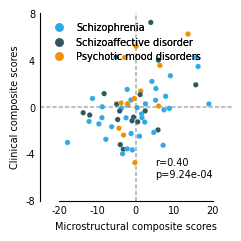

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
scatter = ax.scatter(mend_pls_result["results"]["x_scores"][:, 0], mend_pls_result["results"]["y_scores"][:, 0],
           s=15, c=post_hoc['group_code'], cmap=cmap_bgo_3, linewidths=0.1, edgecolors='white')
ax.axvline(x=0, c="silver", zorder=0, ls=(0, (2, 1)))
ax.axhline(y=0, c="silver", zorder=0, ls=(0, (2, 1)))
ax.set(xlim=(-25, 25), ylim=(-8, 8), xticks=[-20, -10, 0, 10, 20], yticks=[-8, -4, 0, 4, 8],
       xlabel="Microstructural composite scores", ylabel="Clinical composite scores")

ax.text(5, -6, f"r={score_corr_r:.2f}\np={score_corr_p:.2e}")
sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

handles, previous_labels = scatter.legend_elements()
legend = ax.legend(handles=handles, labels=group_names, loc="upper left", bbox_to_anchor=(0, 1.0), frameon=False)
ax.add_artist(legend)
fig.savefig(figs_dir / "mend_score_corr.svg")

In [ ]:
def plot_raincloud(x, ax):
    pos = np.array([1, 2, 3])
    v1 = ax.violinplot(x, positions=pos+0.2,
                    showmeans=False, showextrema=False, showmedians=False)

    for b, c in zip(v1['bodies'], pal_bgo_3):
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_facecolor(c)
        b.set_linewidth(0)

    b1 = ax.boxplot(x, positions=pos, patch_artist=True, widths=0.15)

    for item in ['boxes']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, facecolor=c, edgecolor=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['medians']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, color=c)
    for item in ['whiskers', 'caps']:
        for i, patch in enumerate(b1[item]):
            c = pal_bgo_3[int(i/2)]
            plt.setp(patch, color=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['fliers']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, markeredgecolor=c)

    e1 = ax.eventplot(x, orientation="vertical", lineoffsets=pos-0.2, linelengths=0.1, colors=pal_bgo_3)

    return v1, b1, e1

In [ ]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print(pingouin.ttest(x_scores_grouped[i], x_scores_grouped[j]))

               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.919495  39.997297   two-sided  0.363349  [-2.36, 6.31]  0.252415   

         BF10     power  
T-test  0.407  0.136808  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.168515  29.901883   two-sided  0.867313  [-4.58, 3.88]  0.045834   

         BF10     power  
T-test  0.326  0.052063  
               T        dof alternative    p-val          CI95%   cohen-d  \
T-test -1.035168  27.339973   two-sided  0.30966  [-6.92, 2.28]  0.365629   

         BF10     power  
T-test  0.522  0.157532  


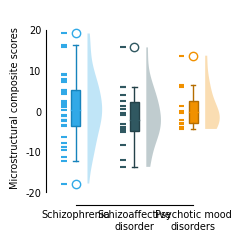

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
v1, b1, e1 = plot_raincloud(x_scores_grouped, ax)

ax.set(ylim=(-23, 25), yticks=[-20, -10, 0, 10, 20], xticklabels=group_names_short,
       ylabel="Microstructural composite scores")
sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
fig.savefig(figs_dir / "mend_x_scores.svg")

In [ ]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print(pingouin.ttest(y_scores_grouped[i], y_scores_grouped[j]))

               T       dof alternative     p-val          CI95%   cohen-d  \
T-test -1.069399  26.86746   two-sided  0.294404  [-2.25, 0.71]  0.341405   

         BF10     power  
T-test  0.459  0.211334  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -1.591246  13.968453   two-sided  0.133925  [-3.73, 0.55]  0.670195   

         BF10     power  
T-test  0.855  0.500301  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.719256  20.641631   two-sided  0.480047  [-3.18, 1.55]  0.278389   

         BF10     power  
T-test  0.425  0.111463  


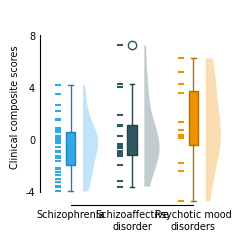

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
v1, b1, e1 = plot_raincloud(y_scores_grouped, ax)

ax.set(ylim=(-5, 10), yticks=[-4, 0, 4, 8], xticklabels=group_names_short,
        ylabel="Clinical composite scores")
sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both',length=0)

fig.savefig(figs_dir / "mend_y_scores.svg")

In [16]:
mend_pls_loadings = h5py.File(data_dir / "MEND_pls_loadings.hdf5")

In [17]:
mend_pls_xload = mend_pls_loadings["results/y_loadings"][:, 0]
mend_pls_xload_resort = np.argsort(-1 * mend_pls_loadings["results/y_loadings"][:, 0])
mend_pls_xload_top_idx = np.where(np.abs(sstats.zscore(mend_pls_xload)) > 2)[0]
mend_pls_xload_sq_top_idx = np.where(np.abs(sstats.zscore(mend_pls_xload ** 2)) > 2)[0]
mend_pls_xload_err = (mend_pls_loadings["results/bootres/y_loadings_ci"][:, 0, 1]- mend_pls_loadings["results/bootres/y_loadings_ci"][:, 0, 0]) / 2
mend_pls_xload_top_resort = np.argsort(-1 * mend_pls_loadings["results/y_loadings"][mend_pls_xload_top_idx, 0])
mend_pls_xload_sq_top_resort = np.argsort(-1 * mend_pls_loadings["results/y_loadings"][mend_pls_xload_sq_top_idx, 0])

In [18]:
diff_pred_names = np.loadtxt(data_dir / "JHU_labels.txt", delimiter="\t", dtype=str)

In [ ]:
diff_pred_names_optimized = ["(" + _.replace("_", ") ") for _ in diff_pred_names]
for i in range(len(diff_pred_names_optimized)):
    curr_name = diff_pred_names_optimized[i]
    curr_new = curr_name.split(" ")
    if len(curr_name) >= 40:
        curr_new.insert(-3, "\n")
    elif 40 > len(curr_name) > 25:
        curr_new.insert(-2, "\n")
    diff_pred_names_optimized[i] = " ".join(curr_new)
diff_pred_names_optimized = np.array(diff_pred_names_optimized)

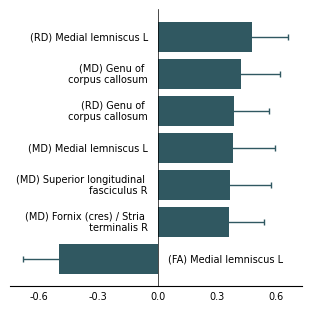

In [ ]:
fig, ax = plt.subplots(figsize=(3.0, 3.0), layout="constrained")

plot_x = np.arange(len(mend_pls_xload_sq_top_resort))
plot_y = -1 * mend_pls_xload[mend_pls_xload_sq_top_idx][mend_pls_xload_sq_top_resort]
ax.barh(plot_x, plot_y,
        xerr=mend_pls_xload_err[mend_pls_xload_sq_top_idx][mend_pls_xload_sq_top_resort], color=pal_bgo_3[1], height=0.8,
        error_kw=dict(ecolor=pal_bgo_3[1], lw=1, capsize=2, capthick=1))
plot_y_pos = np.where(plot_y>0)[0]
plot_y_neg = np.where(plot_y<0)[0]

ax.axvline(x=0, c="black", lw=0.5)

ax.set(xticks=[-0.6, -0.3, 0, 0.3, 0.6], yticks=[])
ax.invert_yaxis()
ax.invert_yaxis()
sns.despine(top=True, right=True, left=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
yticklabels=diff_pred_names_optimized[mend_pls_xload_sq_top_idx][mend_pls_xload_sq_top_resort]
for i in plot_y_neg:
    ax.text(0.05, plot_x[i], yticklabels[i], ha="left", va="center",
            color="k")
for i in plot_y_pos:
    ax.text(-0.05, plot_x[i], yticklabels[i], ha="right", va="center",
            color='k')

fig.savefig(figs_dir / "mend_xload.svg")

In [19]:
mend_pls_yload = mend_pls_result["results/y_loadings"][:, 0]
mend_pls_yload_err = (mend_pls_result["results/bootres/y_loadings_ci"][:, 0, 1]- mend_pls_result["results/bootres/y_loadings_ci"][:, 0, 0]) / 2

mend_pls_yload_resort = np.argsort(-1 * mend_pls_result["results/y_loadings"][:, 0])
mend_pls_yload_top_idx = np.where(
    (np.abs(sstats.zscore(mend_pls_yload)) > 1)
    & ((np.abs(mend_pls_yload)-mend_pls_yload_err)>0)
    )[0]
mend_pls_yload_sq_top_idx = np.where(
    (np.abs(sstats.zscore(mend_pls_yload ** 2)) > 1)
    & ((np.abs(mend_pls_yload)-mend_pls_yload_err)>0)
    )[0]
mend_pls_yload_top_resort = np.argsort(-1 * mend_pls_result["results/y_loadings"][mend_pls_yload_top_idx, 0])
mend_pls_yload_sq_top_resort = np.argsort(-1 * mend_pls_result["results/y_loadings"][mend_pls_yload_sq_top_idx, 0])

In [21]:
mend_scores = pd.read_csv(data_dir / "MEND_scores.csv")

In [22]:
temp = pd.DataFrame(columns=['symptoms', 'coef', 'se'])
temp['symptoms'] = mend_scores["description"].to_numpy()
temp['coef'] = mend_pls_yload
temp['se'] = mend_pls_yload_err

temp

,symptoms,coef,se
0,Somatic Concern,-0.114701,0.267978
1,Anxiety,0.130615,0.256181
2,Emotional Withdrawal,-0.061007,0.226578
3,Conceptual Disorg,0.146767,0.283556
4,Guilt Feelings,-0.072854,0.291548
5,Tension,0.006078,0.207888
6,Mannerisms Posturing,0.030884,0.183294
7,Grandiosity,0.085327,0.213070
8,Depressive Mood,-0.002730,0.290044
9,Hostility,0.129250,0.231643


In [ ]:
score_dimension_to_color = {"pos": "#5C554A", "neg": "#31A9E7", "gen": "#345662", "mania": "#F19100"}

In [ ]:
mend_scores["text_color"] = mend_scores["dimension"].map(score_dimension_to_color)

In [ ]:
for i in range(len(mend_scores)):
    curr_name = mend_scores.loc[i, "description"]
    curr_new = curr_name.split(" ")
    if len(curr_name) >= 40:
        curr_new.insert(-3, "\n")
    elif 40 > len(curr_name) > 23:
        curr_new.insert(-2, "\n")
    mend_scores.loc[i, "description"] = " ".join(curr_new)

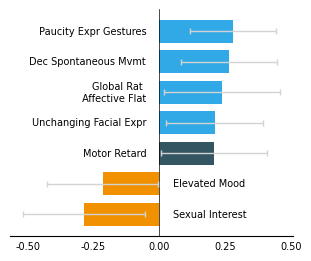

In [ ]:
fig, ax = plt.subplots(figsize=(3.0, 2.5), layout="constrained")

plot_x = np.arange(len(mend_pls_yload_sq_top_resort))
plot_y = mend_pls_yload[mend_pls_yload_sq_top_idx][mend_pls_yload_sq_top_resort]
plot_error = mend_pls_yload_err[mend_pls_yload_sq_top_idx][mend_pls_yload_sq_top_resort]
plot_y_ticklabels = mend_scores["description"].to_numpy()[mend_pls_yload_sq_top_idx][mend_pls_yload_sq_top_resort]
plot_y_ticklabels_color = mend_scores["text_color"].to_numpy()[mend_pls_yload_sq_top_idx][mend_pls_yload_sq_top_resort]
plot_y_pos = np.where(plot_y>0)[0]
plot_y_neg = np.where(plot_y<0)[0]

ax.axvline(x=0, c="black", lw=0.5)

ax.barh(plot_x, -1 * plot_y, xerr=plot_error, color=plot_y_ticklabels_color, height=0.75,
        error_kw=dict(ecolor="lightgray", lw=1, capsize=2, capthick=1))
ax.set(xticks=[-0.5, -0.25, 0, 0.25, 0.5], yticks=plot_x, yticklabels=[])
ax.invert_yaxis()
ax.invert_yaxis()
sns.despine(top=True, right=True, left=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

for i in plot_y_neg:
    ax.text(-0.05, plot_x[i], plot_y_ticklabels[i], ha="right", va="center",
            color="k")
for i in plot_y_pos:
    ax.text(0.05, plot_x[i], plot_y_ticklabels[i], ha="left", va="center",
            color='k')

fig.savefig(figs_dir / "mend_yload.svg")

In [ ]:
from pycirclize import Circos

In [ ]:
mend_scores["yload"] = -1 *mend_pls_yload
mend_pls_yload_sq_top_score_names = mend_scores["description"].to_numpy()[mend_pls_yload_sq_top_idx][mend_pls_yload_sq_top_resort]

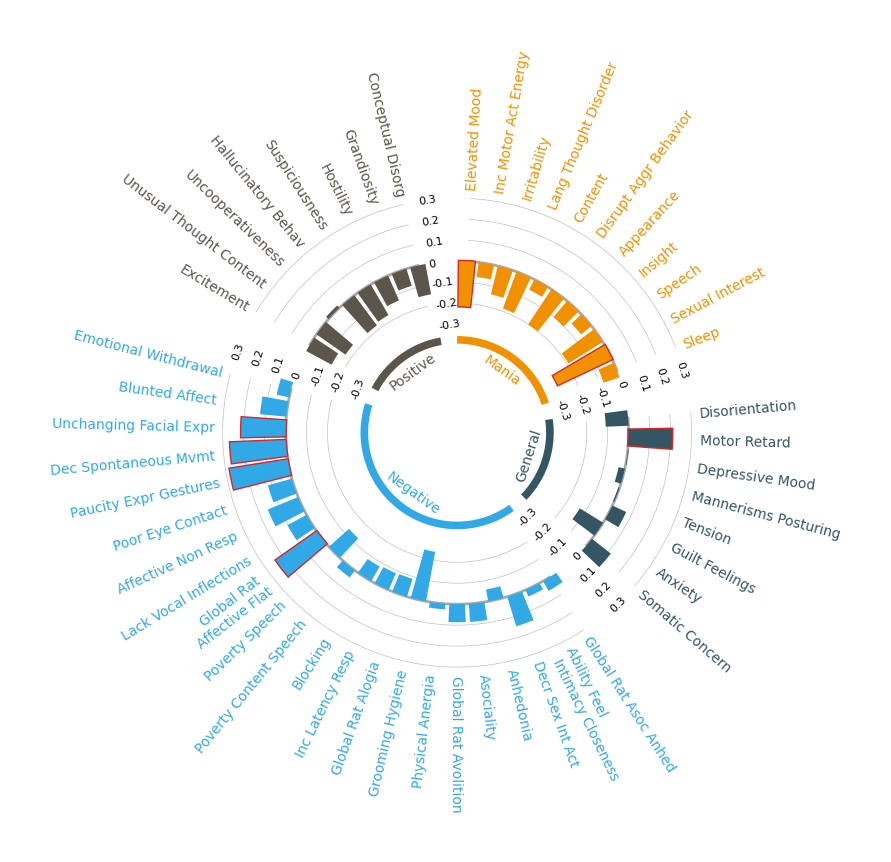

In [ ]:
with matplotlib.rc_context({"svg.fonttype": "path"}):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'}, layout="constrained")

    sectors = {"Mania": 11, "General": 8, "Negative": 22, "Positive": 8}
    circos = Circos(
        sectors, space=10,
        sector2clockwise = {"Positive": False, "Negative": False, "General": False, "Mania": True}
        )

    for sector, dim in zip(circos.sectors, ["mania", "gen", "neg", "pos"]):

        sector.rect(r_lim=(35, 38), color=score_dimension_to_color[dim])
        sector.text(f"{sector.name}", r=27, size=10, color=score_dimension_to_color[dim])

        curr_mend_scores = mend_scores[mend_scores["dimension"]==dim]
        plot_x = np.arange(len(curr_mend_scores)) + 0.5
        plot_y = curr_mend_scores["yload"].to_numpy()
        plot_ylabel = curr_mend_scores["description"].to_numpy()
        vmin, vmax = -0.30, 0.30

        track = sector.add_track((40, 95), r_pad_ratio=0.1)
        # track.axis()
        track.xticks(plot_x, plot_ylabel, label_orientation="vertical", tick_length=0,
                    text_kws={"color": score_dimension_to_color[dim]}, label_size=10)
        track.yticks(y=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], vmin=vmin, vmax=vmax,
                    labels=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], tick_length=0)


        track.line(plot_x, [0]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="darkgray", lw=2, zorder=1)
        for i in [-0.2, -0.1, 0.1, 0.2, 0.3]:
            track.line(plot_x, [i]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="silver", zorder=1)
        track.bar(plot_x, plot_y, vmin=vmin, vmax=vmax, color=score_dimension_to_color[dim], zorder=3)

        plot_ylabel_sig_idx = [i for i, _ in enumerate(plot_ylabel) if _ in mend_pls_yload_sq_top_score_names]
        for curr_idx in plot_ylabel_sig_idx:
            track.bar([plot_x[curr_idx]], [plot_y[curr_idx]], vmin=vmin, vmax=vmax, zorder=2, linewidth=2, edgecolor="tab:red")

    fig = circos.plotfig(ax=ax)
    fig.savefig(figs_dir / "mend_yload_circle.svg")